### **Bank Marketing Campaign**

[Sumber data www.kaggle.com](https://www.kaggle.com/)

### **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
6. Conclusion
7. Recommendation

****

### **Business Problem Understanding**

**Context**

Jenis produk keuangan yang digunakan masyarakat semakin bervariasi. Salah satu produk keuangan yang banyak dikenal masyarakat adalah deposito berjangka. Mekanisme deposito berjangka adalah nasabah menyetorkan sejumlah uangnya ke bank atau lembaga keuangan, dan uang tersebut baru dapat ditarik setelah jangka waktu tertentu. Sebagai imbalannya, nasabah akan diberikan bunga tetap sesuai dengan jumlah nominal uang yang disetorkan.

Meski demikian, sebagai badan usaha yang memiliki produk keuangan dan nasabah masing-masing, bank tetap harus bersaing agar tidak kehilangan nasabah. Salah satu cara untuk mendapatkan pelanggan baru adalah dengan melakukan kampanye pemasaran.

**Problem Statement**

Salah satu tantangan terbesar bagi Bank atau Lembaga Keuangan adalah seberapa efektif marketing campaign dilakukan untuk dapat menarik nasabah untuk menyetorkan uangnya pada deposito berjangka.
Bank perlu mengadakan marketing campaign dengan cara menawarkan program deposito kepada semua nasabahnya, hal ini membutuhkan biaya dan waktu yang ekstra yang dikeluarkan karena semua customer perlu dihubungi dan ditawarkan. Apabila dapat di analisa di awal target customernya maka marketing campaign bisa lebih terarah dan tepat sasaran.


**Goals**

Berdasarkan permasalahan tersebut, Bank atau lembaga keuangan tentu perlu memiliki 'tool' yang dapat memprediksi dan membantu untuk menganalisa customer mana yang memiliki potensi untuk mendepositokan uangnya. sehingga cost marketing dapat dikurangi dan waktu serta effort pun lebih efisien.

### **Data Understanding**

- Dataset merupakan data Bank Marketing Campaign
- Tujuan marketing campaign adalah agar nasabah tertarik dan mengambil produk keuangan yaitu Deposito Berjangka

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| age | Integer | customers age |
| job | Object | customers job |
| balance | Integer | customers balance |
| housing | Object | house status ownership of customer |
| loan | Object | loan status customer |
| contact | Object | Contact communication type |
| month | Object | Last contact month of the year |
| campaign | Integer | Number of contacts performed during this campaign and for this client |
| pdays | Integer | Number of days after the client was contacted from the previous campaign |
| poutcome | Object | Outcome of the previous marketing campaign |
| deposit | Object | Whether the customer deposits or not |

<br>

In [ ]:
!pip install category_encoders

In [ ]:
# Library

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("/content/data_bank_marketing_campaign.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


## DATA CLEANING ##

In [ ]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[92, 48]"
1,job,object,0,0.0,12,"[admin., housemaid]"
2,balance,int64,0,0.0,3153,"[253, 480]"
3,housing,object,0,0.0,2,"[yes, no]"
4,loan,object,0,0.0,2,"[yes, no]"
5,contact,object,0,0.0,3,"[unknown, cellular]"
6,month,object,0,0.0,12,"[nov, sep]"
7,campaign,int64,0,0.0,32,"[28, 1]"
8,pdays,int64,0,0.0,422,"[318, 175]"
9,poutcome,object,0,0.0,4,"[unknown, failure]"


Pada tahap ini, kita akan melakukan cleaning pada data yang nantinya data yang sudah dibersihkan akan kita gunakan untuk proses analisis selanjutnya. Beberapa hal yang perlu dilakukan adalah:
- Menghapus data anomali
- Drop fitur yang tidak memiliki relevansi terhadap permasalahan yang sedang dihadapi.
- Melakukan treatment terhadap missing value jika ada. Bisa dengan cara men-drop fiturnya jika memang tidak dibutuhkan atau bisa juga dengan mengimputasi dengan nilai yang paling masuk akal berdasarkan kasusnya.

In [ ]:
# Membuat duplikasi dataframe
df_model = df.copy()

In [ ]:
df_model.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


## Anomali Data

Terdapat anomali data yaitu:
- customer dengan jumlah saldo tabungan minus

In [ ]:
df_model[df_model.balance < 0]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
5,41,admin.,-76,yes,no,cellular,apr,1,-1,unknown,no
59,50,admin.,-194,yes,no,cellular,apr,2,-1,unknown,no
65,31,services,-327,yes,no,unknown,may,1,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7712,40,management,-63,no,yes,cellular,jul,1,-1,unknown,no
7757,33,technician,-479,no,no,cellular,aug,1,-1,unknown,no
7758,57,retired,-157,no,no,cellular,aug,9,-1,unknown,no
7763,28,management,-994,yes,yes,cellular,jul,2,-1,unknown,no


In [ ]:
# Drop kolom balance yang bernilai minus
df_model = df_model[(df_model['balance'] > 0)]

In [ ]:
# memastikan data anomali sudah tidak ada
df_model[df_model.balance < 0]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit


## Missing Value

**Remove Unknown Data**

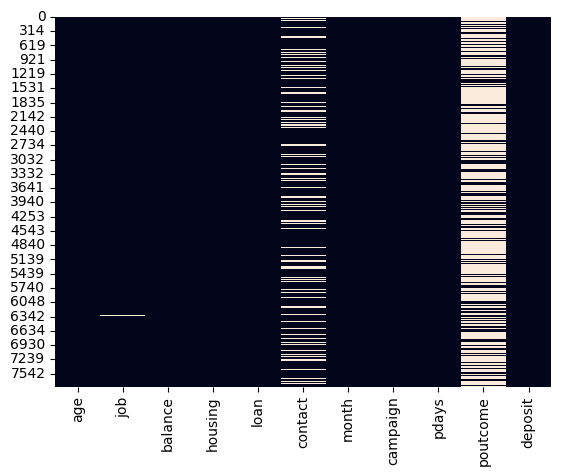

In [ ]:
# Missing value heatmap (berisi data dengan keterangan "unknown")
sns.heatmap(df_model == "unknown", cbar=False);

Terdapat data contact, poutcome dan job yang berisi "unknown" --> hal ini hampir sama dengan data NaN, missing value.
Treatment untuk missing value:
- contact unknown --> replace by mode, direplace oleh data yang sering muncul, menggunakan np.where
- job unknown --> hapus data unknown
- Karena jumlah 'unknown' pada poutcome banyak, jika menggunakan teknik replace missing value dengan nilai modus/mean maka akan tetap menjadi 'unknown' hasilnya. Maka untuk mengakali missing value ini, apabila kolom deposito yes maka poutcome menjadi success, deposito no maka poutcome menjadi failure.

In [ ]:
contact_mode = df_model.contact.mode()[0]
contact_mode

'cellular'

In [ ]:
df_model['contact'] = np.where(
    df_model['contact'] == 'unknown',
    contact_mode,
    df_model['contact']
)
df_model

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
6,37,admin.,4803,no,no,cellular,jan,2,-1,unknown,yes
7,36,technician,911,yes,yes,cellular,may,2,21,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [ ]:
df_model.poutcome.value_counts()

unknown    4971
failure     750
success     721
other       346
Name: poutcome, dtype: int64

Dari sini kita lihat jumlah data poutcome unknown banyak sekali, maka jika kolom deposit yes maka poutcome akan menjadi 'success' jika kolom deposit no maka akan menjadi 'failure'

In [ ]:
df_model['poutcome'] = np.where(
    (df_model['poutcome'] == 'unknown') & (df_model['deposit'] == 'yes'),
    'success',
    'failure'
)
df_model

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,success,yes
2,51,admin.,3025,no,no,cellular,may,1,352,failure,yes
4,36,housemaid,205,yes,no,telephone,nov,4,-1,failure,no
6,37,admin.,4803,no,no,cellular,jan,2,-1,success,yes
7,36,technician,911,yes,yes,cellular,may,2,21,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,success,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,failure,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,failure,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,failure,no


In [ ]:
df_model.job.value_counts()

management       1584
technician       1123
blue-collar      1123
admin.            806
services          554
retired           490
self-employed     248
student           235
unemployed        220
entrepreneur      197
housemaid         159
unknown            49
Name: job, dtype: int64

Data unknown pada fitur job sudah tidak ada, selanjutnya me-replace data 'admin.' menjadi 'admin' supaya tidak terbaca sebagai float

In [ ]:
df_model['job'] = df_model['job'].replace('admin.','admin')
df_model.job.value_counts()

management       1584
technician       1123
blue-collar      1123
admin             806
services          554
retired           490
self-employed     248
student           235
unemployed        220
entrepreneur      197
housemaid         159
unknown            49
Name: job, dtype: int64

In [ ]:
# menghapus data unknown pada kolom 'job'
df_model = df_model.drop(df_model[df_model.job == 'unknown'].index)
df_model


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin,1662,no,no,cellular,jun,2,-1,success,yes
2,51,admin,3025,no,no,cellular,may,1,352,failure,yes
4,36,housemaid,205,yes,no,telephone,nov,4,-1,failure,no
6,37,admin,4803,no,no,cellular,jan,2,-1,success,yes
7,36,technician,911,yes,yes,cellular,may,2,21,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...
7806,53,management,13901,yes,no,cellular,nov,1,-1,failure,no
7808,62,housemaid,2,no,no,cellular,nov,1,-1,success,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,failure,yes
7811,31,admin,54,yes,no,cellular,nov,1,-1,failure,no


In [ ]:
# Pengecekan data job setelah data unknown dihapus
df_model.job.value_counts()

management       1584
technician       1123
blue-collar      1123
admin             806
services          554
retired           490
self-employed     248
student           235
unemployed        220
entrepreneur      197
housemaid         159
Name: job, dtype: int64

Sekarang data unknown sudah dihapus, selanjutnya dilakukan pengecekan terhadap data unknown

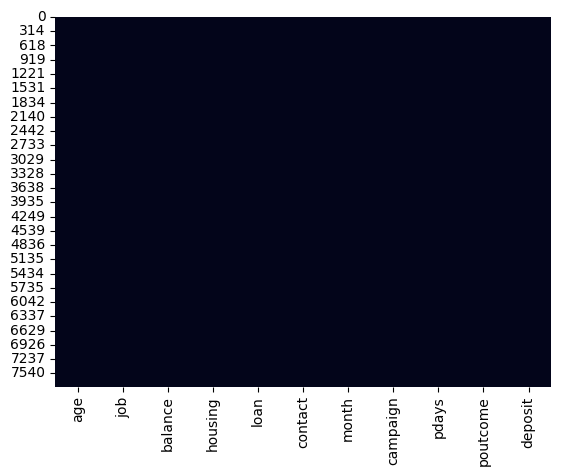

In [ ]:
# Missing value heatmap (berisi data dengan keterangan "unknown")
sns.heatmap(df_model == "unknown", cbar=False);

Tidak ada missing value / data bernilai NaN atau Unknown

In [ ]:
# Cek info dataset yang telah bersih
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6739 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       6739 non-null   int64 
 1   job       6739 non-null   object
 2   balance   6739 non-null   int64 
 3   housing   6739 non-null   object
 4   loan      6739 non-null   object
 5   contact   6739 non-null   object
 6   month     6739 non-null   object
 7   campaign  6739 non-null   int64 
 8   pdays     6739 non-null   int64 
 9   poutcome  6739 non-null   object
 10  deposit   6739 non-null   object
dtypes: int64(4), object(7)
memory usage: 631.8+ KB


## **Data Exploration**

In [ ]:
# numerical feature
nums = df_model.loc[:, (df_model.dtypes == 'int64') | (df_model.dtypes == float)].columns.tolist()
print(nums)
print(len(nums))

['age', 'balance', 'campaign', 'pdays']
4


In [ ]:
# categorical feature
cats = df_model.loc[:, (df_model.dtypes == 'object')].columns.tolist()
print(cats)

['job', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In [ ]:
n_feats = ['age', 'balance', 'campaign']

In [ ]:
df_model[n_feats].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,6739.0,41.19,12.11,18.0,32.0,38.0,49.0,95.0
balance,6739.0,1760.75,3232.31,1.0,258.0,726.0,1967.5,66653.0
campaign,6739.0,2.48,2.68,1.0,1.0,2.0,3.0,63.0


- mayoritas semua customer berumur 41-42 tahun
- rata-rata saldo semua customer berjumlah 1,760.75
- rata-rata semua customer mendapat campaign sebanyak 2-3 x

In [ ]:
df_model[cats].describe().T

,count,unique,top,freq
job,6739,11,management,1584
housing,6739,2,no,3667
loan,6739,2,no,5948
contact,6739,2,cellular,6255
month,6739,12,may,1657
poutcome,6739,2,failure,4624
deposit,6739,2,no,3377


- mayoritas pekerjaan customer adalah di bidang management
- mayoritas customer tidak memiliki rumah dan pinjaman bank
- mayoritas campaign dilakukan via telpon selular ke customer
- mayoritas customer tidak mengambil deposito
- mayoritas hasil campaign tidak membuat customer mengambil deposito

<ipython-input-223-782708681834>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model[n_feats[i]])
<ipython-input-223-782708681834>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model[n_feats[i]])
<ipython-input-223-782708681834>:5: UserWarning: 

`distplot` is a deprecated function a

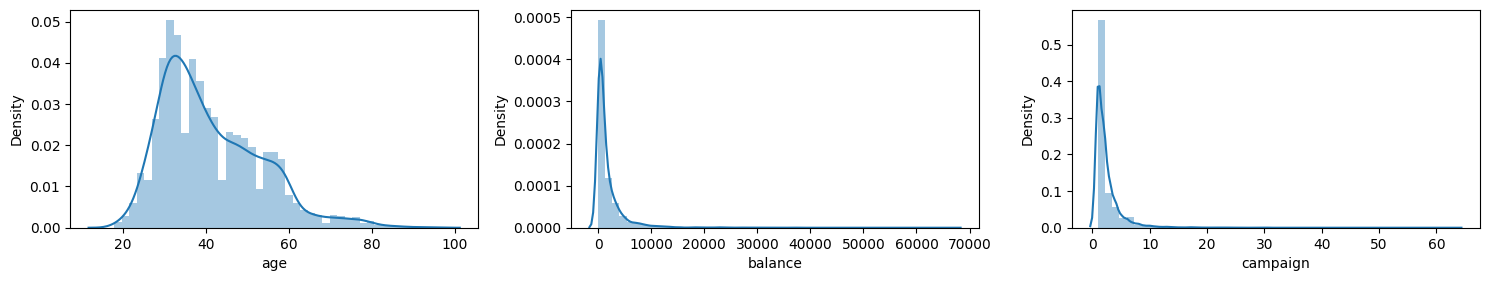

In [ ]:
# cek distribusi fitur numerikal
plt.figure(figsize=(15, 8))
for i in range(0, len(n_feats)):
    plt.subplot(3, 3, i+1)
    sns.distplot(df_model[n_feats[i]])
    plt.tight_layout()

Fitur age, balance dan campaign memiliki distribusi positif skewness

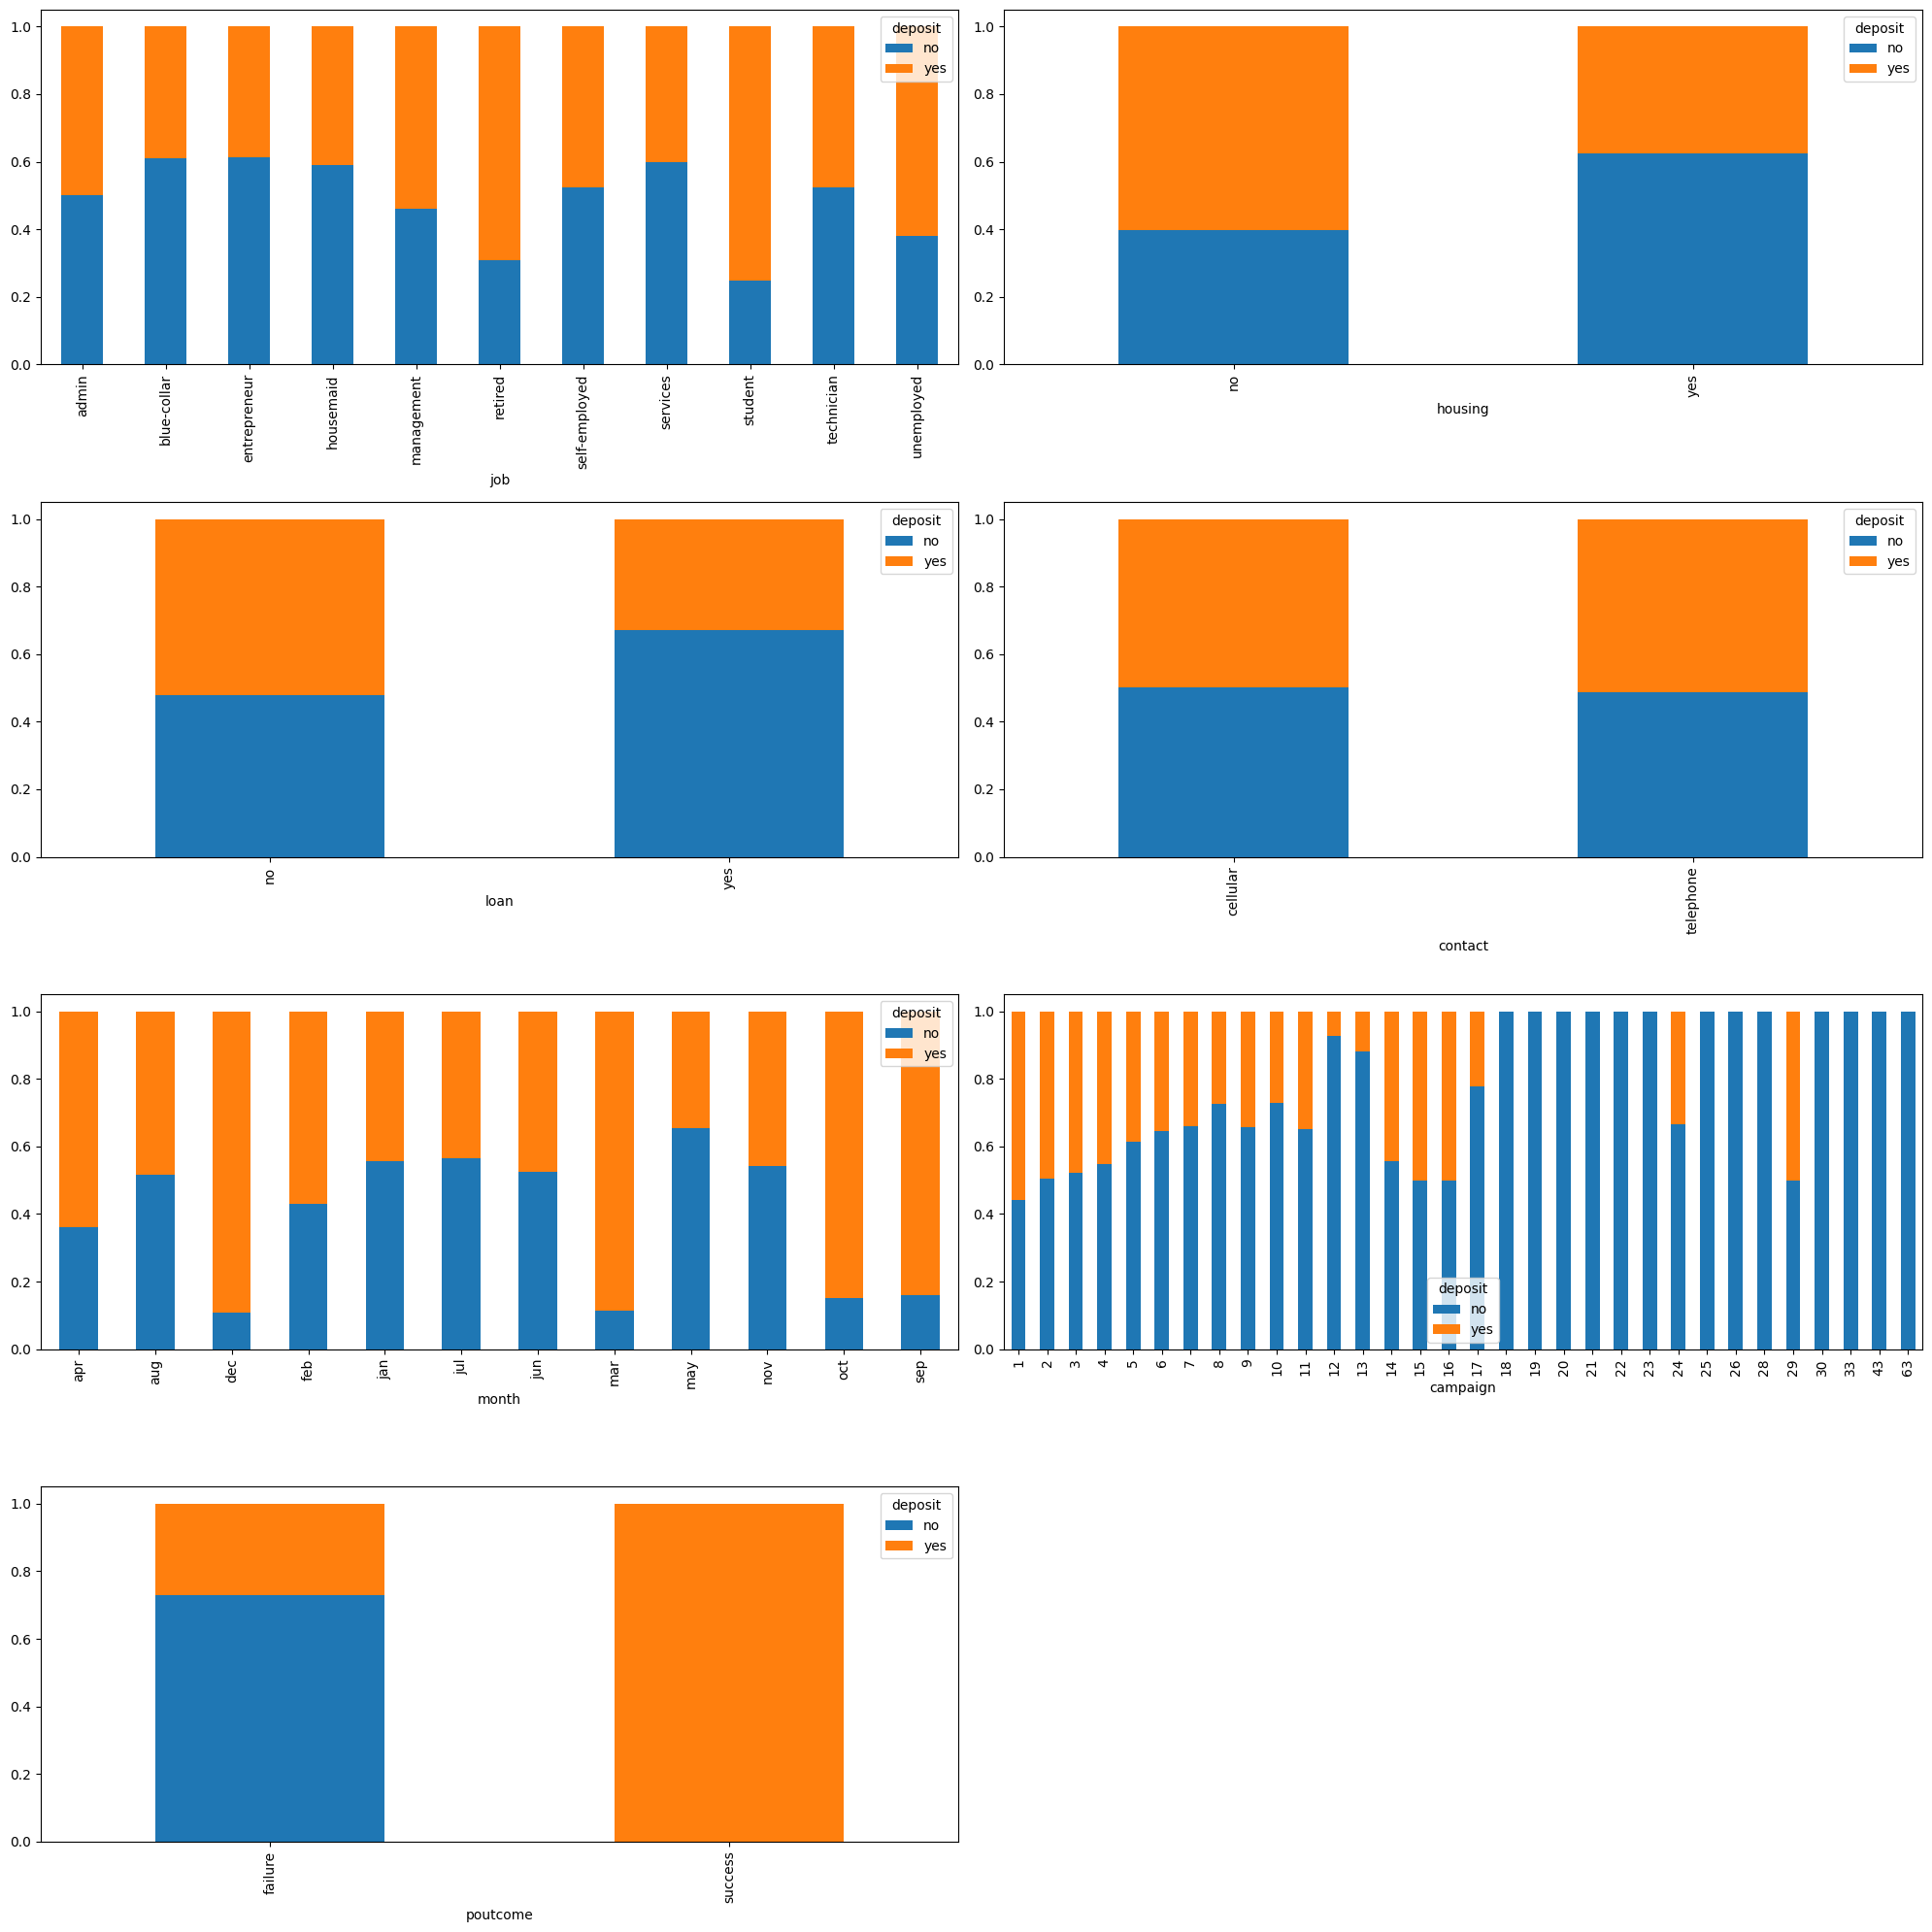

In [ ]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_model.drop(columns=['deposit','pdays', 'age', 'balance']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df_model[i],df_model['deposit'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [ ]:
for i in df_model.drop(columns=['deposit','pdays', 'age', 'balance']).columns:
    relevent_experience_df = df_model.groupby(i)['deposit'].value_counts(normalize=True).unstack()
    display(relevent_experience_df)

deposit,no,yes
job,,
admin,0.502481,0.497519
blue-collar,0.609973,0.390027
entrepreneur,0.614213,0.385787
housemaid,0.591195,0.408805
management,0.460227,0.539773
retired,0.308163,0.691837
self-employed,0.524194,0.475806
services,0.597473,0.402527
student,0.246809,0.753191


deposit,no,yes
housing,,
no,0.398146,0.601854
yes,0.624023,0.375977


deposit,no,yes
loan,,
no,0.478648,0.521352
yes,0.670038,0.329962


deposit,no,yes
contact,,
cellular,0.502158,0.497842
telephone,0.487603,0.512397


deposit,no,yes
month,,
apr,0.361386,0.638614
aug,0.516060,0.483940
dec,0.107692,0.892308
feb,0.430962,0.569038
jan,0.556650,0.443350
jul,0.565060,0.434940
jun,0.525239,0.474761
mar,0.113514,0.886486
may,0.653591,0.346409


deposit,no,yes
campaign,,
1,0.441247,0.558753
2,0.505785,0.494215
3,0.522500,0.477500
4,0.547771,0.452229
5,0.614679,0.385321
6,0.646341,0.353659
7,0.659091,0.340909
8,0.726027,0.273973
9,0.657895,0.342105


deposit,no,yes
poutcome,,
failure,0.73032,0.26968
success,NaN,1.00000


**Kesimpulan Barplot dan Tabel di atas**

- Mayoritas customer yang deposit memiliki job sebagai pelajar, pensiunan, bekerja di bidang manajemen
- Mayoritas customer yang deposit tidak memiliki rumah sendiri
- Mayoritas customer yang deposit tidak memiliki pinjaman
- Mayoritas customer yang deposit di bulan desember, maret, october, september
- Mayoritas customer yang deposit mendapat campaign < 17 x
- Channel campaign via telpon dan selular hampir mirip hasilnya


<ipython-input-226-dc71fb1cd859>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_model.corr(method='pearson')


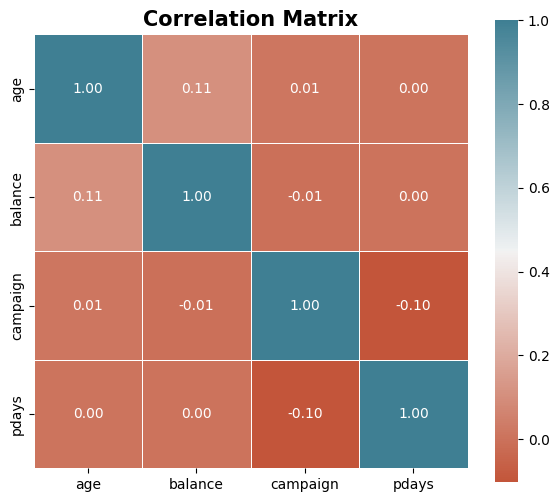

In [ ]:
# Correlation matrix
plt.figure(figsize=(7, 6))
palette=sns.diverging_palette(20, 220, n=256)
corr = df_model.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Correlation Matrix', size=15, weight='bold');

## MODELING ##

**Feature Encoding**

In [ ]:
df_model['deposit'] = np.where(
    (df_model['deposit'] == 'yes'),
    1,
    0
)
df_model['deposit']

0       1
2       1
4       0
6       1
7       1
       ..
7806    0
7808    1
7809    1
7811    0
7812    1
Name: deposit, Length: 6739, dtype: int64

In [ ]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['housing','loan', 'contact']),
    ('binary', ce.BinaryEncoder(), ['job'])
], remainder='passthrough')

In [ ]:
x = df_model[['age', 'balance','campaign', 'job', 'housing', 'loan', 'contact']]
y = df_model['deposit']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    stratify=y,
    random_state=10)
x_train

,age,balance,campaign,job,housing,loan,contact
3964,56,12,3,unemployed,no,no,cellular
1052,42,314,2,housemaid,no,no,cellular
927,35,300,4,technician,yes,no,cellular
3431,44,2999,1,admin,yes,no,cellular
6437,32,2556,3,technician,no,no,cellular
...,...,...,...,...,...,...,...
7291,33,99,2,admin,yes,yes,cellular
7493,20,423,1,blue-collar,yes,no,cellular
4995,37,483,1,services,yes,no,cellular
4139,43,3403,2,services,yes,no,cellular


In [ ]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
testing.head()

,onehot__housing_yes,onehot__loan_yes,onehot__contact_telephone,binary__job_0,binary__job_1,binary__job_2,binary__job_3,remainder__age,remainder__balance,remainder__campaign
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,56.0,12.0,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.0,314.0,2.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,35.0,300.0,4.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,44.0,2999.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,32.0,2556.0,3.0


In [ ]:
x_train_prep = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
x_train_prep

,onehot__housing_yes,onehot__loan_yes,onehot__contact_telephone,binary__job_0,binary__job_1,binary__job_2,binary__job_3,remainder__age,remainder__balance,remainder__campaign
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,56.0,12.0,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.0,314.0,2.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,35.0,300.0,4.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,44.0,2999.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,32.0,2556.0,3.0
...,...,...,...,...,...,...,...,...,...,...
5386,1.0,1.0,0.0,0.0,1.0,0.0,0.0,33.0,99.0,2.0
5387,1.0,0.0,0.0,1.0,0.0,1.0,0.0,20.0,423.0,1.0
5388,1.0,0.0,0.0,0.0,1.0,0.0,1.0,37.0,483.0,1.0
5389,1.0,0.0,0.0,0.0,1.0,0.0,1.0,43.0,3403.0,2.0


In [ ]:
x_test_prep = pd.DataFrame(transformer.fit_transform(x_test),columns=transformer.get_feature_names_out())
x_test_prep

,onehot__housing_yes,onehot__loan_yes,onehot__contact_telephone,binary__job_0,binary__job_1,binary__job_2,binary__job_3,remainder__age,remainder__balance,remainder__campaign
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,44.0,10984.0,18.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0,1534.0,2.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,64.0,661.0,2.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,29.0,3317.0,7.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.0,256.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1343,1.0,0.0,0.0,0.0,0.0,0.0,1.0,54.0,1895.0,1.0
1344,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,1720.0,1.0
1345,1.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,3166.0,3.0
1346,1.0,0.0,0.0,1.0,0.0,0.0,0.0,27.0,511.0,5.0


## **MODELLING AND EVALUATION**

**1.Decision Tree**

In [ ]:
from sklearn import preprocessing

**Decision Tree without Scaling**

In [ ]:
decision_tree_wo_scaling = DecisionTreeClassifier(max_depth= 2)
decision_tree_wo_scaling.fit(x_train_prep, y_train)

DecisionTreeClassifier(max_depth=2)

In [ ]:
pred = decision_tree_wo_scaling.predict(x_test_prep)
accuracy_score(y_test, pred) * 100

64.09495548961425

**Decision Tree With Scaling**

In [ ]:
# feature scaling
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_prep)
x_test_scaled = scaler.transform(x_test_prep)

In [ ]:
decision_tree_w_scaling = DecisionTreeClassifier(max_depth= 2)
decision_tree_w_scaling.fit(x_train_scaled, y_train)

DecisionTreeClassifier(max_depth=2)

In [ ]:
pred = decision_tree_w_scaling.predict(x_test_scaled)
accuracy_score(y_test, pred) * 100

64.09495548961425

Hasil score predict menggunakan Model Decision Tree with/without scaling adalah **64,09 %**

**HYPERPARAMETER TUNING**

In [ ]:
max_depth_tree_list = np.arange(1, 20, 2)
acc_train_list, acc_test_list = [], []
best_precision = 0
best_max = 0

for max_depth_num in max_depth_tree_list:
    # fit the model
    tree_model = DecisionTreeClassifier(max_depth= max_depth_num)
    tree_model.fit(x_train_prep, y_train)

    # make the prediction
    train_pred = tree_model.predict(x_train_prep)
    test_pred = tree_model.predict(x_test_prep)

    train_acc = precision_score(y_train, train_pred)
    test_acc = precision_score(y_test, test_pred)
    acc_train_list.append(train_acc)
    acc_test_list.append(test_acc)

    if best_precision < test_acc:
        best_precision = test_acc
        best_max = max_depth_num

In [ ]:
print("Best precision {}".format(best_precision))
print("Best max_dept {}".format(best_max))

Best precision 0.71875
Best max_dept 5


Setelah hyperparameter tuning, nilai best precision menjadi **71,875 %**

**Validation Splitting**

In [ ]:
# 60% training: 20% validation: 20% testing

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size= .2, stratify= y, random_state= 2020)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_val, y_train_val, test_size= 0.25, stratify= y_train_val, random_state= 2020)

In [ ]:
x_train_prep2 = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
x_test_prep2 = pd.DataFrame(transformer.fit_transform(x_test),columns=transformer.get_feature_names_out())

In [ ]:
x_validation_prep = pd.DataFrame(transformer.fit_transform(x_validation),columns=transformer.get_feature_names_out())
x_train_val_prep = pd.DataFrame(transformer.fit_transform(x_train_val),columns=transformer.get_feature_names_out())

In [ ]:
max_depth_tree_list = np.arange(1, 20, 2)
acc_train_list, acc_test_list = [], []
best_acc = 0
best_max = 0

for max_depth_num in max_depth_tree_list:
    # fit the model
    tree_model = DecisionTreeClassifier(max_depth= max_depth_num)
    tree_model.fit(x_train_prep2, y_train)

    # make the prediction
    train_pred = tree_model.predict(x_train_prep2)
    test_pred = tree_model.predict(x_validation_prep)

    train_acc = precision_score(y_train, train_pred)
    test_acc = precision_score(y_validation, test_pred)
    acc_train_list.append(train_acc)
    acc_test_list.append(test_acc)

    if best_acc < test_acc:
        best_acc = test_acc
        best_max = max_depth_num

In [ ]:
print("Best precision {}".format(best_acc))
print("Best max_dept {}".format(best_max))

Best precision 0.6506622516556292
Best max_dept 5


Setelah validation splitting, score best precision turun menjadi **65,12 %**

In [ ]:
best_tree_model = DecisionTreeClassifier(max_depth= best_max)
best_tree_model.fit(x_train_val_prep, y_train_val)

pred = best_tree_model.predict(x_test_prep2)
precision_score(y_test, pred) * 100

64.98371335504885

Setelah ditesting kinerjanya best precision turun menjadi **64.98%**

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

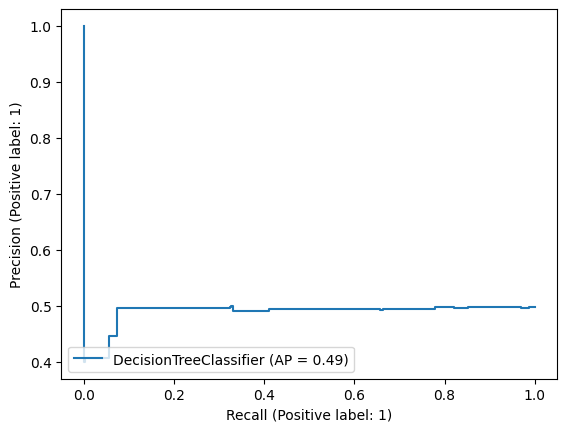

In [ ]:
PrecisionRecallDisplay.from_estimator(best_tree_model, x_test_prep, y_test)

**Cross Validation Splitting**

In [ ]:
# define the parameter list
max_depth_tree_list = np.arange(1, 20, 2)
tree_params_list = {
    'max_depth': max_depth_tree_list,
    'criterion': ['log_loss', 'gini', 'entropy'],
}

In [ ]:
grid_search = GridSearchCV(
    estimator= DecisionTreeClassifier(),
    param_grid= tree_params_list,
    cv= StratifiedKFold(n_splits= 3),
    scoring= 'precision'
)
grid_search.fit(x_train_prep2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['log_loss', 'gini', 'entropy'],
                         'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
             scoring='precision')

In [ ]:
grid_search.best_score_ * 100

65.3902975788129

In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='log_loss', max_depth=3)

In [ ]:
best_model = grid_search.best_estimator_

precision_test_set = precision_score(
    y_test,
    best_model.predict(x_test_prep2)
)

precision_test_set * 100

62.12765957446808

Hasil precision model decision tree adalah **62.12%**

**2. LightGBM**

In [ ]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

**MODEL BENCHMARKING: K-FOLD**



In [ ]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 1613, number of negative: 1621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3234, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498763 -> initscore=-0.004947
[LightGBM] [Info] Start training from score -0.004947
[LightGBM] [Info] Number of positive: 1613, number of negative: 1621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 3234, number of used features: 10
[LightGBM] [Info] [binary:

,mean roc_auc,sdev
model,,
Logistic Regression,0.664394,0.012080
LightGBM,0.662712,0.014029
Random Forest,0.661711,0.015098
XGBoost,0.652686,0.010034
Decision Tree,0.575144,0.014062
KNN,0.538939,0.009201


Hasilnya Model Logistic Regression diikuti LightGBM adalah yang terbaik untuk roc_aucnya

**MODEL BENCHMARKING: TEST DATA**

In [ ]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test

    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.62      0.63      0.62       676
           1       0.62      0.61      0.62       672

    accuracy                           0.62      1348
   macro avg       0.62      0.62      0.62      1348
weighted avg       0.62      0.62      0.62      1348

KNN 
               precision    recall  f1-score   support

           0       0.54      0.53      0.54       676
           1       0.53      0.54      0.54       672

    accuracy                           0.54      1348
   macro avg       0.54      0.54      0.54      1348
weighted avg       0.54      0.54      0.54      1348

Decision Tree 
               precision    recall  f1-score   support

           0       0.58      0.54      0.56       676
           1       0.57      0.61      0.59       672

    accuracy                           0.58      1348
   macro avg       0.58      0.58      0.58      1348
weighted avg       0.58      0

,roc_auc score
model,
LightGBM,0.684671
Random Forest,0.676940
Logistic Regression,0.663446
XGBoost,0.660703
Decision Tree,0.576284
KNN,0.555215


hasil benchmarking test data score roc_auc tertinggi adalah Model LightGBM

Selanjutnya kita akan coba menggunakan Model LightGBM

Reference : https://lightgbm.readthedocs.io/en/latest/index.html

### Test Oversampling with K-Fold Cross Validation

In [ ]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [ ]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [ ]:
data = x_train
target = y_train

In [ ]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):

    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]

#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)

    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)

    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

[LightGBM] [Info] Number of positive: 1815, number of negative: 1823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 3638, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498900 -> initscore=-0.004398
[LightGBM] [Info] Start training from score -0.004398
[LightGBM] [Info] Number of positive: 1823, number of negative: 1823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 3646, number of used features: 10
[LightGBM] [Info] [binary:

#### Evaluation Metrics Without Oversampling

In [ ]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))

dfEvaluate = pd.DataFrame(listItem,
                    columns=['Train Accuracy',
                            'Test Accuracy',
                            'Train ROC AUC',
                            'Test ROC AUC',
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.810060,0.587654,0.894827,0.640882,0.809992,0.586646,0.792837,0.539604,0.820410,0.595628
1,0.802364,0.627160,0.893305,0.677913,0.802328,0.626578,0.790634,0.589109,0.808906,0.636364
2,0.803463,0.597531,0.892451,0.639858,0.803184,0.594674,0.767493,0.514851,0.826216,0.615385
3,0.807914,0.616337,0.894002,0.654666,0.807817,0.616315,0.787328,0.623762,0.820321,0.614634
4,0.797197,0.618812,0.893079,0.662092,0.797028,0.618728,0.770248,0.603960,0.813264,0.622449
5,0.792800,0.631188,0.891181,0.668390,0.792692,0.630806,0.771901,0.599010,0.804710,0.640212
6,0.791976,0.660891,0.887196,0.726706,0.791702,0.660640,0.757576,0.633663,0.812648,0.670157
7,0.801044,0.650990,0.891720,0.687180,0.800988,0.650371,0.785793,0.611940,0.809875,0.661290
8,0.798296,0.591584,0.890412,0.664583,0.797967,0.591522,0.759361,0.582090,0.822792,0.590909
9,0.788678,0.623762,0.883968,0.680416,0.788560,0.623310,0.766520,0.592040,0.801382,0.629630


#### Evaluation Metrics With Oversampling

In [ ]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))

dfEvaluate = pd.DataFrame(listItem,
                    columns=['Train Accuracy',
                            'Test Accuracy',
                            'Train ROC AUC',
                            'Test ROC AUC',
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.801975,0.595062,0.893473,0.640540,0.801925,0.594644,0.786067,0.564356,0.811898,0.600000
1,0.806363,0.612346,0.891881,0.673109,0.806307,0.611578,0.789358,0.569307,0.817149,0.621622
2,0.802798,0.622222,0.894145,0.644515,0.802634,0.618115,0.773999,0.519802,0.821304,0.652174
3,0.794682,0.613861,0.890718,0.647755,0.794625,0.613852,0.777961,0.608911,0.804878,0.615000
4,0.797149,0.628713,0.892531,0.649691,0.797101,0.628676,0.781798,0.618812,0.806561,0.631313
5,0.799068,0.626238,0.893818,0.667263,0.799029,0.626180,0.785088,0.613861,0.807671,0.629442
6,0.793311,0.688119,0.882737,0.727612,0.793207,0.688050,0.770833,0.673267,0.807118,0.693878
7,0.799781,0.633663,0.892155,0.690170,0.799756,0.633088,0.788810,0.597015,0.806506,0.641711
8,0.802523,0.586634,0.891076,0.666777,0.802287,0.586631,0.767965,0.592040,0.824985,0.583333
9,0.796215,0.653465,0.891281,0.690219,0.796172,0.653253,0.781679,0.631841,0.805085,0.658031


Perbedaan hasil without/with Oversampling adalah:
1. Accuracy turun 0.1%
2. ROC turun 0.2%
3. F1 Score naik 0.6%
4. Recall turun 0.1%
5. Precision turun 0.2%

Hasil tanpa oversampling lebih baik meningkatkan score walaupun tidak signifikan perbedaannya

#### Classification Reports Without Oversampling

In [ ]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       203
           1       0.60      0.54      0.57       202

    accuracy                           0.59       405
   macro avg       0.59      0.59      0.59       405
weighted avg       0.59      0.59      0.59       405

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       203
           1       0.64      0.59      0.61       202

    accuracy                           0.63       405
   macro avg       0.63      0.63      0.63       405
weighted avg       0.63      0.63      0.63       405

              precision    recall  f1-score   support

           0       0.58      0.68      0.63       203
           1       0.62      0.51      0.56       202

    accuracy                           0.60       405
   macro avg       0.60      0.60      0.59       405
weighted avg       0.60      0.60      0.59       405

              preci

#### Classification Reports With Oversampling

In [ ]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       203
           1       0.60      0.56      0.58       202

    accuracy                           0.60       405
   macro avg       0.60      0.59      0.59       405
weighted avg       0.60      0.60      0.59       405

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       203
           1       0.62      0.57      0.59       202

    accuracy                           0.61       405
   macro avg       0.61      0.61      0.61       405
weighted avg       0.61      0.61      0.61       405

              precision    recall  f1-score   support

           0       0.60      0.72      0.66       203
           1       0.65      0.52      0.58       202

    accuracy                           0.62       405
   macro avg       0.63      0.62      0.62       405
weighted avg       0.63      0.62      0.62       405

              preci

Hasil dari classification report with oversampling lebih stabil daripada without oversampling.

##**CONCLUSION**

Berdasarkan pemodelan yang dilakukan menggunakan:
- Decision Tree menghasilkan best precision 62.12%
- LightGBM menghasilan precision 66%



Berdasarkan hasil classification report dari model LightGBM dapat disimpulkan seandainya akan menggunakan model untuk memfilter customer yang akan ditawarkan deposito, maka model dapat mengurangi 67% customer yang tidak tertarik untuk tidak ditawarkan, dan model kita mendapatkan 63% customer yang tertarik dari seluruh customer yang tertarik. (Berdasarkan recallnya)

Model ini memiliki ketepatan prediksi customer yang tertarik sebesar 66% (precisionnya), Setiap model memprediksi bahwa customer tertarik, maka kemungkinan predict benar itu sebesar 66%. Maka masih akan ada customer yang sebenarnya tidak tertarik tetapi diprediksi sebagai customer yang tertarik sekitar 33% dari keseluruhan customer yang tidak tertarik (berdasarkan recall)

Jika asumsi biaya marketing campaign untuk 1 orang sebesar $10

Dengan Model (hanya customer yang diprediksi oleh model tertarik yang kita tawarkan) :
- Total Biaya => (63 x 10 USD) + (33 x 10 USD) = 630 USD + 330 USD = 960 USD
- Total Kandidat Tertarik yang didapatkan => 63 orang (karena recall 1/yg tertarik itu 63%)
- Total Kandidat Tertarik yang tidak didapatkan => 37 orang (karena recall 1/yg tertarik itu 63%)
- Biaya yang terbuang => 33 x 10 USD = 330 USD (berdasarkan recall 0/yg tidak tertarik (33 orang menolak tawaran/tidak tertarik))
- Jumlah penghematan => 67 x 10 USD = 670 USD (yang dihitung hanya yang memang tidak tertarik saja, kalau yang tertarik tapi tidak ditawarkan itu tidak dihitung disini)

Dengan model membantu Bank untuk saving cost dan juga waktu sehingga cukup dengan menawarkan ke customer yang potensial tertarik mengambil deposito saja.

##**RECOMMENDATION**

- Mengatasi pengisian data "unknown" pada data job, akan lebih baik jika job ini sudah terklasifikasi didalam sebuah list jadi customer cukup memilih, menghindari data unknown
- Melengkapi data evaluasi marketing campaign terutama pada data contact dan poutcome yang berisi banyak data "unknown", supaya data untuk analisa dapat lebih baik dan akurasinya tinggi
- Penambahan fitur lain yang dapat berkaitan terutama customer profile, yang dapat membantu model dalam prediksi data lebih baik lagi
- Mencoba model machine learning dan mencoba hyperparameter tuning yang berbeda, untuk mencari yang terbaik.

**Thank You**